## Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from IPython.display import Image
import imageio
import os
import time
import pickle

tpu = True


In [2]:
# Pour executer le code sur tpu :
# 1) Mettre tpu = True
# 2) Changer le type d'éxecution à TPU dans l'onglet execution
# 3) Lancer cette cellule avec la deuxieme ligne non commentée puis redemarrer l'environnement et commenter la ligne
if tpu:
    assert os.environ['COLAB_TPU_ADDR']
    # !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    import torch_xla
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
else:
    dev ='cpu'


## Network Definition

### Layers

In [3]:
def build_generator(n_img,n_noise):
    # Encoder network
    generator = nn.Sequential(
        
        nn.Linear(n_noise, 256*7*7), 
        nn.Unflatten(1,(256,7,7)),
        
        nn.ConvTranspose2d(256, 128, 3,stride=2,padding=1,output_padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(128, 64, 3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(64,1, 3,stride=2,padding=1,output_padding=1),
        nn.Tanh(),
    )
    return generator

In [4]:
def build_discriminator(n_img,loss):
    # Encoder network
    discriminator = nn.Sequential(
        
        nn.Conv2d(1, 64, 3,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(64,128, 3,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Flatten(),
        nn.Linear(128*7*7,1))
    
    return discriminator

### Module Class


In [5]:
class GAN(nn.Module):
    def __init__(self,flags):
        super().__init__()
        self.G = build_generator(flags['n_img'],flags['n_noise'])
        self.D = build_discriminator(flags['n_img'],flags['loss'])
        self.dev = flags['device']

    def generate(self, noise):
        return self.G(noise)#.view(-1, 1, 28, 28)
    def discriminate(self,image):
        x = image
        return self.D(x).view(-1,1)


    def compute_gp(self, images, fakes):
        batch_size = images.size(0)
        eps = torch.rand(batch_size, 1, 1, 1).to(self.dev)
        eps = eps.expand_as(images)
        interpolation = eps * images + (1 - eps) * fakes
        interp_logits = self.discriminate(interpolation)
        grad_outputs = torch.ones_like(interp_logits)

        gradients = torch.autograd.grad(
            outputs=interp_logits,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.view(batch_size, -1)
        grad_norm = gradients.norm(2, 1)
        return torch.mean((grad_norm - 1) ** 2)

### Data Loader

In [6]:
def import_data(batch_size):
# Transforms to apply to the images
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
# Import the train dataset
  path = r'.\Dataset'
  trainset = torchvision.datasets.MNIST(root=path, train=True, download=True, transform=transform)
  if small_set==True:
    trainset, val_set = torch.utils.data.random_split(trainset, [2048, len(trainset)-2048])

  if tpu == True:
    train_sampler = torch.utils.data.distributed.DistributedSampler(trainset,
                                                                      num_replicas = xm.xrt_world_size(),
                                                                      rank         = xm.get_ordinal(),
                                                                      shuffle      = True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=flags['batch_size'],sampler=train_sampler,num_workers=0,pin_memory=True)
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=flags['batch_size'])

  return(trainloader)

### Some utility Functions

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
      
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
def imshow(img,ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if ax==None:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()
    else:
      ax.imshow(np.transpose(npimg, (1, 2, 0)))
    
# save the generated images as GIF file
def save_gif(img_list):
    to_pil_image = transforms.ToPILImage()

    imgs = [np.array(to_pil_image(vutils.make_grid(img, padding=2))) for img in img_list]
    imageio.mimsave('./generator_images.gif', imgs)

def test_loader(trainloader):
# get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
# show images
    images.shape
    imshow(torchvision.utils.make_grid(images[:64]))
    plt.show()

In [9]:
class MyHingeLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, output, target,dev):
        return (torch.mean(torch.maximum(1 - torch.mul(output, target),torch.zeros(output.shape[0],1).to(dev)),0))

class MyLinearLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        return torch.mean(torch.mul(target,output),0)     


## Running Functions

### Initialisation

In [10]:
def create_network(flags,dev):
  trainloader = import_data(flags['batch_size'])
  fixed_noise = torch.randn(64, flags['n_noise']).to(dev) #Fixed noise for evaluation of the samples

  my_gan = GAN(flags)
  my_gan = xmp.MpModelWrapper(my_gan).to(dev)
  
  my_gan.G.apply(weights_init)
  my_gan.D.apply(weights_init)

  if flags['loss'] == 'wass':
    criterion1 = MyLinearLoss()
    criterion2 = MyLinearLoss()
  
  if flags['optim'] == 'rmsprop':
    optimizerG = optim.RMSprop(my_gan.G.parameters(),lr=flags['lr'])
    optimizerD = optim.RMSprop(my_gan.D.parameters(),lr=flags['lr'])
  else:
    optimizerG = optim.Adam(my_gan.G.parameters(),lr=flags['lr'], betas=(0.5, 0.999))
    optimizerD = optim.Adam(my_gan.D.parameters(),lr=flags['lr'], betas=(0.5, 0.999))
  
  my_gan.D.train()
  my_gan.G.train()

  return(my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise)



### Training Loop

In [20]:
def train(flags,my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise,dev):
  
  img_list,G_losses,D_losses,accuracies1,accuracies2 = [],[],[],[],[]
  
  for epoch in range(flags['num_epochs']): 
        time_start = time.time()      
        D_loss,G_loss = 0.,0. #Variables for storing the losses

        # Select the DataLoader
        if tpu:
            para_loader = pl.ParallelLoader(trainloader, [dev])
            loader = para_loader.per_device_loader(dev)
        else:
            loader = trainloader

        iters_g ,iters_d =0 , 0 
        for i, data in enumerate(loader):        
            current_bsize = data[0].shape[0]  

            #### TRAINING THE DISCRIMINATOR #####
            optimizerD.zero_grad()
            label_real = (flags['label_real'] + torch.zeros(current_bsize,1)).to(dev)
            label_fake = (flags['label_fake'] + torch.zeros(current_bsize,1)).to(dev) 
            #REAL DATA
            output_real = my_gan.discriminate(data[0])
            #TFAKE DATA
            noise = torch.randn(current_bsize, flags['n_noise']).to(dev)
            fakes = my_gan.generate(noise)
            output_fake = my_gan.discriminate(fakes)
            
            #COMPUTE LOSS
            errD_real = criterion1(output_real, label_real)
            errD_fake = criterion1(output_fake, label_fake)  


            loss_im = (errD_real + errD_fake)
            loss_grad = my_gan.compute_gp(data[0],fakes)
            loss = loss_im + flags['grad_penalty'] * loss_grad


            loss.backward()
          
            if tpu:
                xm.optimizer_step(optimizerD)
            else:
                optimizerD.step()
            
            if flags['clipping'] == True:
                for p in my_gan.D.parameters():
                  p.data.clamp_(-0.01, 0.01)

            #Saving the loss
          
            D_loss+=loss.item()
            iters_d +=1
            #### TRAINING THE GENERATOR #####
            if (i+1)%flags['epochs_discr'] == 0:
              optimizerG.zero_grad()
              label = (flags['label_real'] + torch.zeros(current_bsize,1)).to(dev)
              noise = torch.randn(current_bsize, flags['n_noise']).to(dev)
              fakes = my_gan.generate(noise)
              output = my_gan.discriminate(fakes)
              errG = criterion2(output, label)
              errG.backward()
              if tpu:
                xm.optimizer_step(optimizerG)
              else:
                optimizerG.step()
              G_loss+=errG.item()
              iters_g += 1
        
        #On calcule la loss moyennée sur le batch
        G_loss,D_loss = G_loss/(iters_g),D_loss/(iters_d)
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        time_end = time.time()
        time_spent = time_end-time_start          
        xm.master_print('[%d/%d] \tTime Spent: %.4f \tLoss_D: %.4f   \tLoss_G:  %.4f'
                      % (epoch, flags['num_epochs'], time_spent,
                        D_loss, G_loss))
            
        with torch.no_grad():
            fakes = my_gan.generate(fixed_noise)
            img_list.append(fakes)
            
            if xm.is_master_ordinal() and epoch%20 == 0: # On montre les images toutes les 20 epochs
              image = vutils.make_grid(fakes.cpu(), padding=2, normalize=False)
              plt.figure()
              plt.axis("off")
              plt.title("Epoch : " + str(i) +" Image Generation")
              imshow(image)
              plt.show()
        
        if xm.is_master_ordinal() and epoch%20 == 0  or epoch==flags['num_epochs']-1: # On sauve les données et le modèle toutes les 20 epoches
          open_file = open('Outputs_'+flags['Simu_name']+'.pkl', "wb")
          pickle.dump([D_losses,G_losses,accuracies1,accuracies2,img_list], open_file)
          open_file.close()
  return(D_losses,G_losses,accuracies1,accuracies2,img_list)

In [21]:
def map_fn(index,flags): #Map function pour le calcul multi-coeurs
  dev = xm.xla_device()
  flags['device'] = dev
  torch.manual_seed(flags['seed'])
  my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise = create_network(flags,dev)
  D_losses,G_losses,accuracies1,accuracies2,img_list = train(flags,my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise,dev)
  
  open_file = open('Outputs.pkl', "wb")
  pickle.dump([my_gan,D_losses,G_losses,accuracies1,accuracies2,img_list], open_file)
  open_file.close()


## Train the model

In [18]:
test = False
if test:
  dev = 'cpu'
  my_gan = GAN(flags).to(dev)
  fixed_noise = torch.randn(3, flags['n_noise']).to(dev)
  fake = my_gan.generate(fixed_noise)
  output = my_gan.discriminate(fake).to(dev)
  print(output)
  print(my_gan._compute_gp( fake*2, fake))

[0/200] 	Time Spent: 55.8363 	Loss_D: -0.0064   	Loss_G:  -0.0057


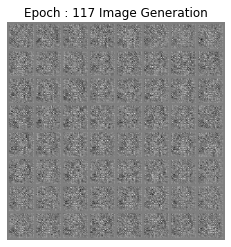

[1/200] 	Time Spent: 23.9894 	Loss_D: -0.0092   	Loss_G:  -0.0088
[2/200] 	Time Spent: 24.7380 	Loss_D: -0.0174   	Loss_G:  -0.0105
[3/200] 	Time Spent: 24.3864 	Loss_D: -0.0256   	Loss_G:  -0.0115
[4/200] 	Time Spent: 24.5562 	Loss_D: -0.0353   	Loss_G:  -0.0122
[5/200] 	Time Spent: 25.1349 	Loss_D: -0.0482   	Loss_G:  -0.0107
[6/200] 	Time Spent: 24.0252 	Loss_D: -0.0633   	Loss_G:  -0.0083
[7/200] 	Time Spent: 24.2222 	Loss_D: -0.0820   	Loss_G:  -0.0044
[8/200] 	Time Spent: 24.3179 	Loss_D: -0.0997   	Loss_G:  -0.0024
[9/200] 	Time Spent: 24.3757 	Loss_D: -0.1156   	Loss_G:  -0.0024
[10/200] 	Time Spent: 24.8683 	Loss_D: -0.1291   	Loss_G:  -0.0036
[11/200] 	Time Spent: 24.7917 	Loss_D: -0.1403   	Loss_G:  -0.0039
[12/200] 	Time Spent: 24.3649 	Loss_D: -0.1511   	Loss_G:  -0.0028
[13/200] 	Time Spent: 23.8076 	Loss_D: -0.1616   	Loss_G:  0.0001
[14/200] 	Time Spent: 24.1994 	Loss_D: -0.1706   	Loss_G:  0.0037
[15/200] 	Time Spent: 24.5732 	Loss_D: -0.1778   	Loss_G:  0.0059
[16/200

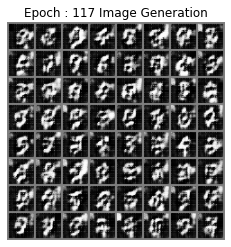

[21/200] 	Time Spent: 24.8906 	Loss_D: -0.1896   	Loss_G:  0.0206
[22/200] 	Time Spent: 24.7893 	Loss_D: -0.1856   	Loss_G:  0.0210
[23/200] 	Time Spent: 30.9902 	Loss_D: -0.1803   	Loss_G:  0.0212
[24/200] 	Time Spent: 25.4429 	Loss_D: -0.1742   	Loss_G:  0.0197
[25/200] 	Time Spent: 25.5504 	Loss_D: -0.1671   	Loss_G:  0.0183
[26/200] 	Time Spent: 25.6023 	Loss_D: -0.1598   	Loss_G:  0.0161
[27/200] 	Time Spent: 24.7421 	Loss_D: -0.1523   	Loss_G:  0.0143
[28/200] 	Time Spent: 24.6612 	Loss_D: -0.1451   	Loss_G:  0.0118
[29/200] 	Time Spent: 24.9702 	Loss_D: -0.1381   	Loss_G:  0.0101
[30/200] 	Time Spent: 24.6825 	Loss_D: -0.1310   	Loss_G:  0.0075
[31/200] 	Time Spent: 25.4871 	Loss_D: -0.1239   	Loss_G:  0.0052
[32/200] 	Time Spent: 25.3302 	Loss_D: -0.1176   	Loss_G:  0.0030
[33/200] 	Time Spent: 24.2265 	Loss_D: -0.1114   	Loss_G:  0.0028
[34/200] 	Time Spent: 24.3816 	Loss_D: -0.1050   	Loss_G:  0.0017
[35/200] 	Time Spent: 25.0668 	Loss_D: -0.0993   	Loss_G:  0.0015
[36/200] 	

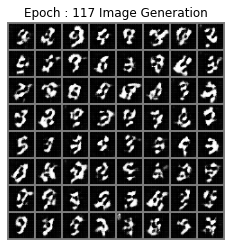

[41/200] 	Time Spent: 23.4604 	Loss_D: -0.0682   	Loss_G:  0.0037
[42/200] 	Time Spent: 24.6339 	Loss_D: -0.0639   	Loss_G:  0.0030
[43/200] 	Time Spent: 24.1566 	Loss_D: -0.0599   	Loss_G:  0.0031
[44/200] 	Time Spent: 24.6926 	Loss_D: -0.0563   	Loss_G:  0.0006
[45/200] 	Time Spent: 24.7889 	Loss_D: -0.0529   	Loss_G:  -0.0013
[46/200] 	Time Spent: 24.4016 	Loss_D: -0.0499   	Loss_G:  -0.0018
[47/200] 	Time Spent: 28.8133 	Loss_D: -0.0470   	Loss_G:  -0.0032
[48/200] 	Time Spent: 24.8702 	Loss_D: -0.0440   	Loss_G:  -0.0053
[49/200] 	Time Spent: 24.1728 	Loss_D: -0.0412   	Loss_G:  -0.0060
[50/200] 	Time Spent: 25.5167 	Loss_D: -0.0388   	Loss_G:  -0.0079
[51/200] 	Time Spent: 24.6181 	Loss_D: -0.0366   	Loss_G:  -0.0059
[52/200] 	Time Spent: 24.9102 	Loss_D: -0.0344   	Loss_G:  -0.0073
[53/200] 	Time Spent: 25.0873 	Loss_D: -0.0323   	Loss_G:  -0.0080
[54/200] 	Time Spent: 24.0884 	Loss_D: -0.0305   	Loss_G:  -0.0090
[55/200] 	Time Spent: 24.1634 	Loss_D: -0.0289   	Loss_G:  -0.0074

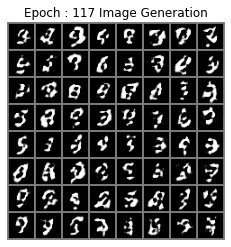

[61/200] 	Time Spent: 24.8531 	Loss_D: -0.0216   	Loss_G:  -0.0020
[62/200] 	Time Spent: 25.5723 	Loss_D: -0.0210   	Loss_G:  0.0022
[63/200] 	Time Spent: 24.9306 	Loss_D: -0.0203   	Loss_G:  -0.0001
[64/200] 	Time Spent: 26.6729 	Loss_D: -0.0195   	Loss_G:  0.0006
[65/200] 	Time Spent: 25.3309 	Loss_D: -0.0189   	Loss_G:  0.0004
[66/200] 	Time Spent: 24.5440 	Loss_D: -0.0185   	Loss_G:  0.0010
[67/200] 	Time Spent: 24.0319 	Loss_D: -0.0178   	Loss_G:  0.0009
[68/200] 	Time Spent: 25.2291 	Loss_D: -0.0174   	Loss_G:  0.0023
[69/200] 	Time Spent: 24.7971 	Loss_D: -0.0170   	Loss_G:  0.0006
[70/200] 	Time Spent: 25.1071 	Loss_D: -0.0166   	Loss_G:  0.0020
[71/200] 	Time Spent: 24.8620 	Loss_D: -0.0160   	Loss_G:  0.0005
[72/200] 	Time Spent: 28.9412 	Loss_D: -0.0155   	Loss_G:  0.0004
[73/200] 	Time Spent: 25.0806 	Loss_D: -0.0151   	Loss_G:  0.0013
[74/200] 	Time Spent: 24.8881 	Loss_D: -0.0147   	Loss_G:  -0.0004
[75/200] 	Time Spent: 24.9715 	Loss_D: -0.0145   	Loss_G:  -0.0052
[76/20

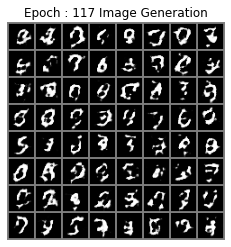

[81/200] 	Time Spent: 26.0093 	Loss_D: -0.0128   	Loss_G:  -0.0066
[82/200] 	Time Spent: 27.5204 	Loss_D: -0.0125   	Loss_G:  -0.0031
[83/200] 	Time Spent: 27.3262 	Loss_D: -0.0125   	Loss_G:  -0.0045
[84/200] 	Time Spent: 28.5538 	Loss_D: -0.0126   	Loss_G:  -0.0009
[85/200] 	Time Spent: 27.3403 	Loss_D: -0.0125   	Loss_G:  0.0016
[86/200] 	Time Spent: 27.3006 	Loss_D: -0.0123   	Loss_G:  0.0000
[87/200] 	Time Spent: 28.3640 	Loss_D: -0.0120   	Loss_G:  -0.0003
[88/200] 	Time Spent: 26.8270 	Loss_D: -0.0117   	Loss_G:  0.0049
[89/200] 	Time Spent: 26.4044 	Loss_D: -0.0116   	Loss_G:  0.0056
[90/200] 	Time Spent: 25.7301 	Loss_D: -0.0114   	Loss_G:  0.0070
[91/200] 	Time Spent: 27.1640 	Loss_D: -0.0113   	Loss_G:  0.0076
[92/200] 	Time Spent: 26.2433 	Loss_D: -0.0111   	Loss_G:  0.0112
[93/200] 	Time Spent: 27.4057 	Loss_D: -0.0110   	Loss_G:  0.0104
[94/200] 	Time Spent: 28.0394 	Loss_D: -0.0108   	Loss_G:  0.0085
[95/200] 	Time Spent: 28.3559 	Loss_D: -0.0106   	Loss_G:  0.0090
[96/2

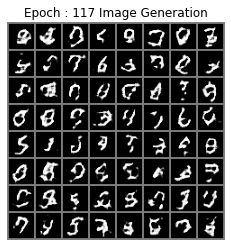

[101/200] 	Time Spent: 27.3614 	Loss_D: -0.0101   	Loss_G:  0.0167
[102/200] 	Time Spent: 26.8823 	Loss_D: -0.0100   	Loss_G:  0.0156
[103/200] 	Time Spent: 26.6637 	Loss_D: -0.0101   	Loss_G:  0.0178
[104/200] 	Time Spent: 27.2406 	Loss_D: -0.0099   	Loss_G:  0.0188
[105/200] 	Time Spent: 29.7566 	Loss_D: -0.0099   	Loss_G:  0.0182
[106/200] 	Time Spent: 27.6824 	Loss_D: -0.0098   	Loss_G:  0.0213
[107/200] 	Time Spent: 24.2886 	Loss_D: -0.0099   	Loss_G:  0.0228
[108/200] 	Time Spent: 25.4134 	Loss_D: -0.0096   	Loss_G:  0.0220
[109/200] 	Time Spent: 24.9444 	Loss_D: -0.0096   	Loss_G:  0.0210
[110/200] 	Time Spent: 24.4070 	Loss_D: -0.0096   	Loss_G:  0.0222
[111/200] 	Time Spent: 24.5205 	Loss_D: -0.0095   	Loss_G:  0.0216
[112/200] 	Time Spent: 24.3891 	Loss_D: -0.0094   	Loss_G:  0.0236
[113/200] 	Time Spent: 24.3294 	Loss_D: -0.0094   	Loss_G:  0.0259
[114/200] 	Time Spent: 24.7173 	Loss_D: -0.0093   	Loss_G:  0.0246
[115/200] 	Time Spent: 24.6360 	Loss_D: -0.0091   	Loss_G:  0.

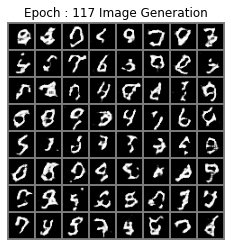

[121/200] 	Time Spent: 23.6637 	Loss_D: -0.0085   	Loss_G:  0.0218
[122/200] 	Time Spent: 24.7211 	Loss_D: -0.0084   	Loss_G:  0.0202
[123/200] 	Time Spent: 24.2704 	Loss_D: -0.0083   	Loss_G:  0.0238
[124/200] 	Time Spent: 25.1974 	Loss_D: -0.0082   	Loss_G:  0.0244
[125/200] 	Time Spent: 24.8671 	Loss_D: -0.0080   	Loss_G:  0.0246
[126/200] 	Time Spent: 24.7665 	Loss_D: -0.0080   	Loss_G:  0.0241
[127/200] 	Time Spent: 25.4895 	Loss_D: -0.0080   	Loss_G:  0.0241
[128/200] 	Time Spent: 25.0260 	Loss_D: -0.0078   	Loss_G:  0.0253
[129/200] 	Time Spent: 24.8699 	Loss_D: -0.0078   	Loss_G:  0.0255
[130/200] 	Time Spent: 24.9601 	Loss_D: -0.0078   	Loss_G:  0.0234
[131/200] 	Time Spent: 25.3569 	Loss_D: -0.0076   	Loss_G:  0.0205
[132/200] 	Time Spent: 24.7064 	Loss_D: -0.0074   	Loss_G:  0.0208
[133/200] 	Time Spent: 25.6829 	Loss_D: -0.0075   	Loss_G:  0.0171
[134/200] 	Time Spent: 25.7537 	Loss_D: -0.0074   	Loss_G:  0.0191
[135/200] 	Time Spent: 24.7462 	Loss_D: -0.0073   	Loss_G:  0.

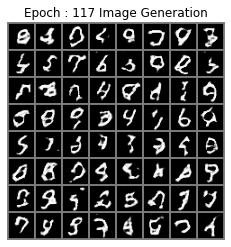

[141/200] 	Time Spent: 24.2180 	Loss_D: -0.0069   	Loss_G:  0.0200
[142/200] 	Time Spent: 25.2948 	Loss_D: -0.0070   	Loss_G:  0.0187
[143/200] 	Time Spent: 24.7918 	Loss_D: -0.0068   	Loss_G:  0.0209
[144/200] 	Time Spent: 25.1806 	Loss_D: -0.0068   	Loss_G:  0.0190
[145/200] 	Time Spent: 25.6562 	Loss_D: -0.0068   	Loss_G:  0.0189
[146/200] 	Time Spent: 26.1829 	Loss_D: -0.0068   	Loss_G:  0.0189
[147/200] 	Time Spent: 26.3178 	Loss_D: -0.0067   	Loss_G:  0.0193
[148/200] 	Time Spent: 25.1347 	Loss_D: -0.0066   	Loss_G:  0.0172
[149/200] 	Time Spent: 24.5834 	Loss_D: -0.0066   	Loss_G:  0.0181
[150/200] 	Time Spent: 25.1955 	Loss_D: -0.0066   	Loss_G:  0.0179
[151/200] 	Time Spent: 26.0139 	Loss_D: -0.0065   	Loss_G:  0.0207
[152/200] 	Time Spent: 25.4064 	Loss_D: -0.0064   	Loss_G:  0.0186
[153/200] 	Time Spent: 25.2540 	Loss_D: -0.0064   	Loss_G:  0.0199
[154/200] 	Time Spent: 24.6968 	Loss_D: -0.0063   	Loss_G:  0.0198
[155/200] 	Time Spent: 24.3950 	Loss_D: -0.0063   	Loss_G:  0.

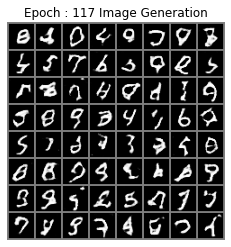

[161/200] 	Time Spent: 23.7638 	Loss_D: -0.0061   	Loss_G:  0.0171
[162/200] 	Time Spent: 24.8611 	Loss_D: -0.0061   	Loss_G:  0.0164
[163/200] 	Time Spent: 24.8610 	Loss_D: -0.0061   	Loss_G:  0.0188
[164/200] 	Time Spent: 25.3044 	Loss_D: -0.0061   	Loss_G:  0.0173
[165/200] 	Time Spent: 24.6762 	Loss_D: -0.0061   	Loss_G:  0.0165
[166/200] 	Time Spent: 26.7958 	Loss_D: -0.0060   	Loss_G:  0.0179
[167/200] 	Time Spent: 25.5470 	Loss_D: -0.0060   	Loss_G:  0.0191
[168/200] 	Time Spent: 24.7322 	Loss_D: -0.0059   	Loss_G:  0.0185
[169/200] 	Time Spent: 24.7700 	Loss_D: -0.0059   	Loss_G:  0.0194
[170/200] 	Time Spent: 25.2819 	Loss_D: -0.0058   	Loss_G:  0.0197
[171/200] 	Time Spent: 26.6063 	Loss_D: -0.0060   	Loss_G:  0.0189
[172/200] 	Time Spent: 25.0571 	Loss_D: -0.0058   	Loss_G:  0.0189
[173/200] 	Time Spent: 24.7362 	Loss_D: -0.0059   	Loss_G:  0.0193
[174/200] 	Time Spent: 24.6941 	Loss_D: -0.0059   	Loss_G:  0.0181
[175/200] 	Time Spent: 25.8220 	Loss_D: -0.0058   	Loss_G:  0.

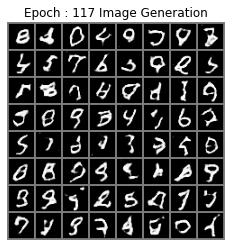

[181/200] 	Time Spent: 24.0416 	Loss_D: -0.0057   	Loss_G:  0.0198
[182/200] 	Time Spent: 25.7646 	Loss_D: -0.0056   	Loss_G:  0.0191
[183/200] 	Time Spent: 25.1273 	Loss_D: -0.0057   	Loss_G:  0.0194
[184/200] 	Time Spent: 25.2853 	Loss_D: -0.0056   	Loss_G:  0.0208
[185/200] 	Time Spent: 25.2179 	Loss_D: -0.0057   	Loss_G:  0.0191
[186/200] 	Time Spent: 25.0420 	Loss_D: -0.0056   	Loss_G:  0.0208
[187/200] 	Time Spent: 24.9929 	Loss_D: -0.0056   	Loss_G:  0.0200
[188/200] 	Time Spent: 25.0027 	Loss_D: -0.0056   	Loss_G:  0.0205
[189/200] 	Time Spent: 24.2769 	Loss_D: -0.0056   	Loss_G:  0.0209
[190/200] 	Time Spent: 25.5616 	Loss_D: -0.0056   	Loss_G:  0.0209
[191/200] 	Time Spent: 25.6914 	Loss_D: -0.0056   	Loss_G:  0.0201
[192/200] 	Time Spent: 24.7890 	Loss_D: -0.0055   	Loss_G:  0.0205
[193/200] 	Time Spent: 24.7318 	Loss_D: -0.0055   	Loss_G:  0.0203
[194/200] 	Time Spent: 24.6347 	Loss_D: -0.0055   	Loss_G:  0.0207
[195/200] 	Time Spent: 24.4901 	Loss_D: -0.0055   	Loss_G:  0.

In [22]:
flags = {}
flags['clipping'] = True
flags['grad_penalty'] = 0
flags['Simu_name'] = 'Wass_Clipping'
flags['loss'] = 'wass'
flags['label_real'] = 1
flags['label_fake'] = -1

flags['optim'] = 'rmsprop'

flags['epochs_discr'] = 1
flags['n_img'] = 28
flags['n_noise'] = 100
flags['lr'] = 1e-5
flags['batch_size'] = 64
flags['num_epochs']= 200
flags['seed'] = 1234
small_set = False

xmp.spawn(map_fn, args=(flags,), nprocs=8, start_method='fork')

## Results

In [1]:
def plot_results(file,create_gif=False):
  open_file = open(file, "rb")
  [D_losses,G_losses,accuracies1,accuracies2,img_list] = pickle.load(open_file)
  open_file.close()

  # save_gif(img_list)
  f,ax = plt.subplots(1,1,figsize=(16,5))
  ax.plot(G_losses,label='Generator Loss')
  ax.plot(D_losses,label='Discriminator Loss')
  ax.legend()
  ax.set_xlabel('Epochs')

  plt.savefig('./loss.png')

  # Plot the fake images from the last epoch
  fakes = img_list[-1].cpu()
  len(img_list)
  images = vutils.make_grid(fakes, padding=2, normalize=False,nrow = 32)
  # Plot the fake images from the last epoch

  plt.figure(figsize=(16,4))
  plt.axis("off")
  plt.title("Last Epoch Image Generation")
  imshow(images)
  plt.show() 

In [2]:
plot_results('Outputs_Wass_Clipping.pkl')

NameError: ignored

Outputs_BCE_LOSS


RuntimeError: ignored

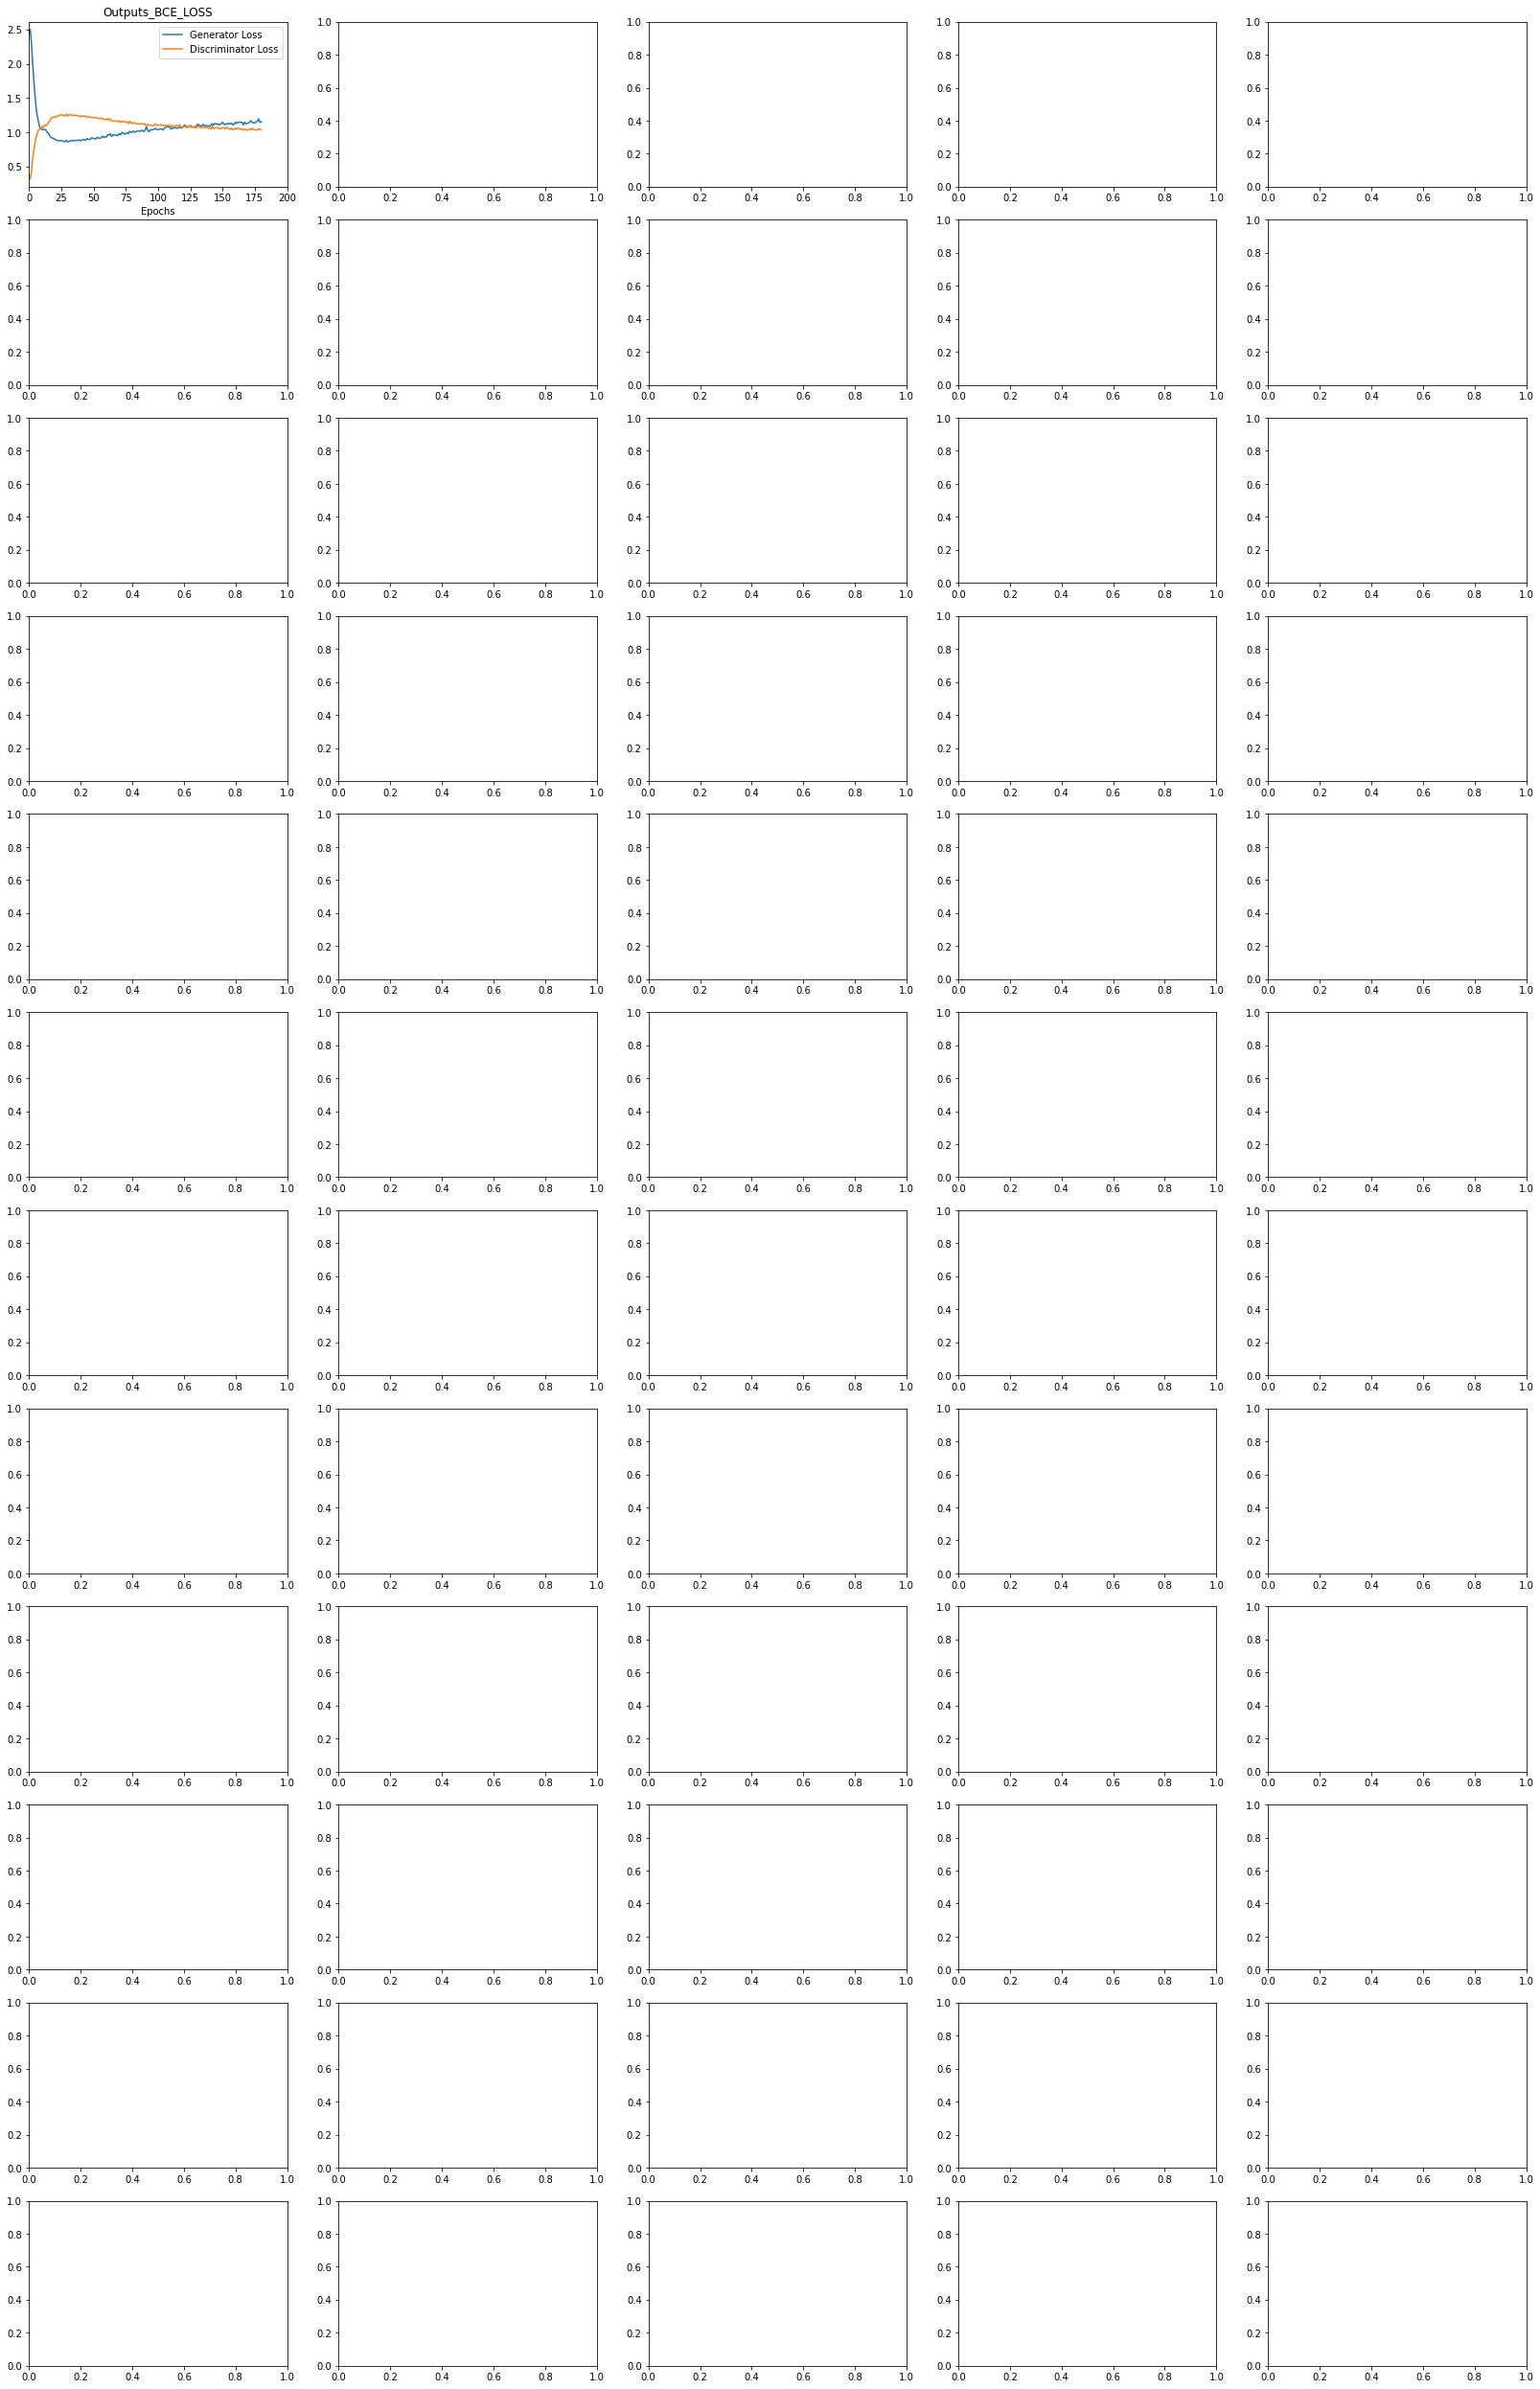

In [29]:
filenames = ['Outputs_BCE_LOSS','Outputs_MSE_Loss','Outputs_HINGE','Outputs_WASSERSTEIN','Outputs_Wass_Grad_pen']
f,ax = plt.subplots(12,len(filenames),figsize=(28,45))


for j,filename in enumerate(filenames):
  print(filename)
  open_file = open(filename+'.pkl', "rb")
  [my_gan,D_losses,G_losses,accuracies1,accuracies2,img_list] = pickle.load(open_file)
  open_file.close()

  # save_gif(img_list)
  ax[0,j].set_title(filename)
  ax[0,j].plot(G_losses,label='Generator Loss')
  ax[0,j].plot(D_losses,label='Discriminator Loss')
  ax[0,j].legend()
  ax[0,j].set_xlabel('Epochs')
  ax[0,j].set_xlim(0,200)


  # ax[1,j].plot(np.array(accuracies1)*100,label='Accuracy real images')
  # ax[1,j].plot(np.array(accuracies2)*100,label='Accuracy fakes')
  # ax[1,j].legend()



  # plt.savefig('./loss.png')


  # Plot the fake images from the last epoch

  # Plot the fake images from the last epoch
  nb_image=199

  for i in range(1,11+1):
    
    index = max(1,(i - 1)*20-1)
    fakes = img_list[index].cpu()
    images = vutils.make_grid(fakes, padding=2, normalize=False,nrow=16)
    ax[i,j].axis("off")
    ax[i,j].set_title('Epoch = '+str(index))
    # ax[i,j].set_title("Last Epoch Image Generation")
    imshow(images,ax=ax[i,j])
    # plt.show()
    # Image(url='.\generator_images.gif',width = 800, height = 500)  

In [ ]:
len(img_list)